# CNNGeometric : Demo on how to apply the transformation

Runs a trained network on an image, displaying the source and target side by side.

**SEE README.md TO GET THE WEIGHTS FOR DEMO.**

In [1]:
from __future__ import print_function, division
import os
import argparse
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from model.cnn_geometric_model import CNNGeometric
from data.pf_dataset import PFDataset
from data.download_datasets import download_PF_willow
from image.normalization import NormalizeImageDict, normalize_image
from util.torch_util import BatchTensorToVars, str_to_bool
from geotnf.transformation import GeometricTnf
from geotnf.point_tnf import *
import matplotlib.pyplot as plt
from skimage import io
import warnings
from torchvision.transforms import Normalize
from collections import OrderedDict

warnings.filterwarnings('ignore')

## Load models

We have to initialize them using `CNNGeometric(...)`. Take a look at CNNGeometric to figure out what arguments to use.

Importantly, output_dim specifies the output dimension of the Feature Regressor, and has different dimensions depending on what transformation you use:
- Affine : output_dim = 6
- Homology : 
    - Four points homology : output_dim = 8
    - Not four points homology : output_dim = 9
- Thin-plate : output_dim = 18


In [2]:
use_cuda = torch.cuda.is_available()
model_aff_path = '../base_weights/best_streetview_checkpoint_adam_affine_grid_loss_PAMI.pth.tar'
model_tps_path = '../base_weights/best_streetview_checkpoint_adam_tps_grid_loss_PAMI.pth.tar'
do_aff = not model_aff_path==''
do_tps = not model_tps_path==''

# Create model
print('Creating CNN model...')

if do_aff:
    model_aff = CNNGeometric(output_dim=6,use_cuda=use_cuda,
                             feature_extraction_cnn='vgg')
if do_tps:
    model_tps = CNNGeometric(output_dim=18,use_cuda=use_cuda,
                             feature_extraction_cnn='vgg')

print('Loading trained model weights...')
if do_aff:
    checkpoint = torch.load(model_aff_path, map_location=lambda storage, loc: storage)
    checkpoint['state_dict'] = OrderedDict([(k.replace('vgg', 'model'), v) for k, v in checkpoint['state_dict'].items()])
    model_aff.load_state_dict(checkpoint['state_dict'])
    print('aff done')
if do_tps:
    checkpoint = torch.load(model_tps_path, map_location=lambda storage, loc: storage)
    checkpoint['state_dict'] = OrderedDict([(k.replace('vgg', 'model'), v) for k, v in checkpoint['state_dict'].items()])
    model_tps.load_state_dict(checkpoint['state_dict'])
    print('tps done')


Creating CNN model...
Loading trained model weights...
aff done
tps done


## Load and preprocess images

Using means/stds from Imagenet, i.e. 
`normalizeTnf = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`

In [5]:
#Here resizes to 240x240 with bi-linear sampling
resizeCNN = GeometricTnf(out_h=240, out_w=240, use_cuda = False) 
tpsTnf = GeometricTnf(geometric_model='tps', use_cuda=use_cuda)
affTnf = GeometricTnf(geometric_model='affine', use_cuda=use_cuda)

means=[0.485, 0.456, 0.406]
stds=[0.229, 0.224, 0.225]
def alt_preprocess_image(image,means,stds):
    """
    CALLED alt_preprocess_image because it differs a little bit from the one provided in the demo notebook
    """
    # convert to torch Variable
    image = np.expand_dims(image.transpose((2,0,1)),0)
    image = torch.Tensor(image.astype(np.float32)/255.0)
    image_var = Variable(image,requires_grad=False)
    # Resize image using bilinear sampling with identity affine tnf
    image_var = resizeCNN(image_var)
    # Normalize image
    image_var = normalize_image(image_var,mean=means,std=stds)
    return image_var

use_cuda = True
def apply_pair(source,target):
    #Redundant, reloads the image
    source_image = io.imread(source)
    target_image = io.imread(target)
    image_tmp = torch.Tensor(target_image.astype(np.float32)/255.0)
    #Getting means/stds
    R_mean, R_std = image_tmp[:,:,0].mean(), image_tmp[:,:,0].std()
    G_mean, G_std = image_tmp[:,:,1].mean(), image_tmp[:,:,1].std()
    B_mean, B_std = image_tmp[:,:,2].mean(), image_tmp[:,:,2].std()
    means = [R_mean, G_mean, B_mean]
    stds = [R_std, G_std, B_std]
    means=[0.485, 0.456, 0.406]
    stds=[0.229, 0.224, 0.225]
    #Use the preprocess method declared above to resize, normalize using the means and std computed above
    source_image_var = alt_preprocess_image(source_image,means=means, stds=stds)
    target_image_var = alt_preprocess_image(target_image,means=means, stds=stds)
    
    if use_cuda:
        source_image_var = source_image_var.cuda()
        target_image_var = target_image_var.cuda()
    #Create a "batch" (i.e. a pair) for the next cell below
    batch = {'source_image': source_image_var, 'target_image':target_image_var}
    #Resize target: create a function that will resize a given input into the target_image's dimension
    resizeTgt = GeometricTnf(out_h=target_image.shape[0], out_w=target_image.shape[1], use_cuda = use_cuda) 
    print(target_image.shape[0],target_image.shape[1])
    #Set the models to eval mode
    if do_aff:
        model_aff.eval()
    if do_tps:
        model_tps.eval()

        
    # Evaluate models and get the thetas
    if do_aff:
        theta_aff=model_aff(batch)
        warped_image_aff = affTnf(batch['source_image'],theta_aff.view(-1,2,3))
    
    if do_tps:
        theta_tps=model_tps(batch)
        warped_image_tps = tpsTnf(batch['source_image'],theta_tps)
    
    if do_aff and do_tps:
        theta_aff_tps=model_tps({'source_image': warped_image_aff, 'target_image': batch['target_image']})        
        warped_image_aff_tps = tpsTnf(warped_image_aff,theta_aff_tps)
    if do_aff:
        warped_image_aff_np = normalize_image(resizeTgt(warped_image_aff),forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()
    
    if do_tps:
        warped_image_tps_np = normalize_image(resizeTgt(warped_image_tps),forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()
    
    if do_aff and do_tps:
        warped_image_aff_tps_np = normalize_image(resizeTgt(warped_image_aff_tps),forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()
    N_subplots = 2+int(do_aff)+int(do_tps)+int(do_aff and do_tps)
    fig, axs = plt.subplots(1,N_subplots)
    axs[0].imshow(source_image)
    axs[0].set_title('src')
    axs[1].imshow(target_image)
    axs[1].set_title('tgt')
    subplot_idx = 2
    if do_aff:
        axs[subplot_idx].imshow(warped_image_aff_np)
        axs[subplot_idx].set_title('aff')
        subplot_idx +=1 
    if do_tps:
        axs[subplot_idx].imshow(warped_image_tps_np)
        axs[subplot_idx].set_title('tps')
        subplot_idx +=1 
    if do_aff and do_tps:
        axs[subplot_idx].imshow(warped_image_aff_tps_np)
        axs[subplot_idx].set_title('aff+tps')
    
    for i in range(N_subplots):
        axs[i].axis('off')
    
    fig.set_dpi(330)
    plt.show()

1453 1600


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


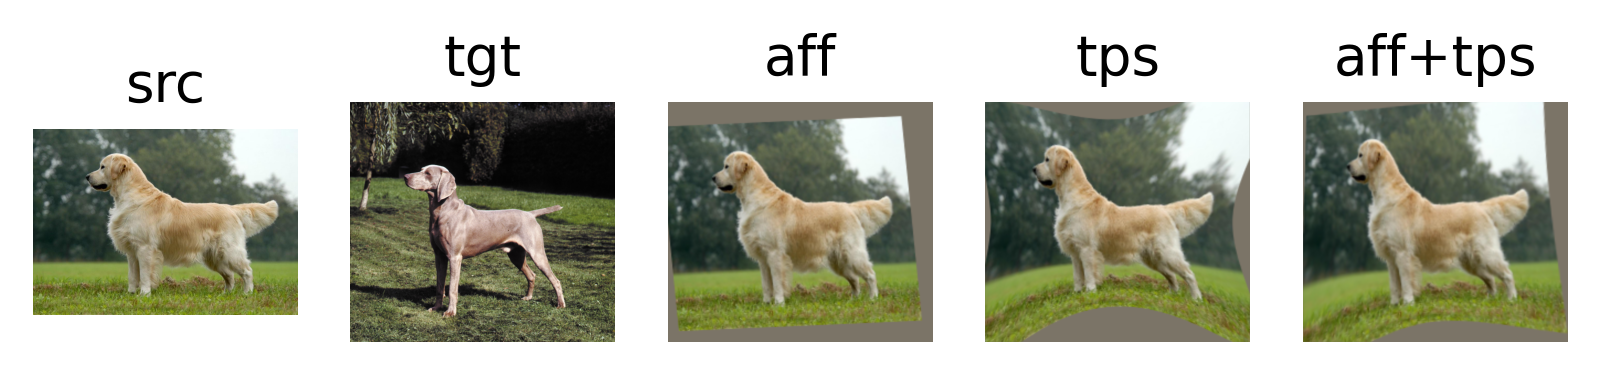

In [9]:
source= 'datasets/demo/dog_source.jpg'
target= 'datasets/demo/dog_target.jpg'
apply_pair(source,target)